In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('../')
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.optimize import brentq
from scipy.stats import binom
import pandas as pd
import seaborn as sns
from prod.serialize_model import serialize_model
from prod.evaluate import load_datasets, evaluate
from sklearn.metrics import roc_curve

In [2]:
# Problem setup
n=5000
n_train = 3000
n_val = 1000
alpha_hi = 0.1 # 1-desired probability of being ICH in high-risk group (PPV)
alpha_lo = 0.04 # 1-desired probability of being non-ICH in low-risk group (NPV)
delta = 0.1 # delta is the failure rate
lambdas = np.linspace(0,1,5000)
model_str = 'logistic'

model_dict = serialize_model(model_str, 1-alpha_hi, 1-alpha_lo, delta, None, n_train, n_val, save=False)

In [3]:
model_dict

{'cls': <prod.arch.LogisticRegression.LogisticRegressionClassifierAbstention at 0x1062b11c0>,
 'date': None,
 'desired_ppv': 0.9,
 'desired_npv': 0.96,
 'tolerance': 0.1,
 'n_train': 3000,
 'n_val': 1000,
 'ppv': 0.9411764705882353,
 'npv': 0.959902794653706,
 'coverage': 0.857,
 'fn': 33,
 'fp': 2,
 'tp': 32,
 'tn': 790,
 'ppv_small': 1.0,
 'npv_small': 0.9393442622950819,
 'coverage_small': 0.7932285368802903,
 'fn_small': 37,
 'fp_small': 0,
 'tp_small': 46,
 'tn_small': 573}

In [4]:
sgmds, labels, parsing_id, diagnostic_id, sgmds_small, labels_small = load_datasets(ids=True)

In [5]:
print(f"Total number of data points: {sgmds.shape[0]}")
os.makedirs('./plots/', exist_ok=True)

cls = model_dict['cls']
out = cls.predict(sgmds)
phats_hi = cls.predict_proba(sgmds)[:,1]
phats_lo = cls.predict_proba(sgmds)[:,0]

# Remove training data
sgmds = sgmds[n_train:]
phats_hi = phats_hi[n_train:]
phats_lo = phats_lo[n_train:]
labels = labels[n_train:]
out = out[n_train:]
parsing_id = parsing_id[n_train:]
diagnostic_id = diagnostic_id[n_train:]

Total number of data points: 9122


In [6]:
# Split the data into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (phats_hi.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_sgmds, val_sgmds = sgmds[idx], sgmds[~idx]
cal_phats_hi, val_phats_hi = phats_hi[idx], phats_hi[~idx]
cal_phats_lo, val_phats_lo = phats_lo[idx], phats_lo[~idx]
cal_labels, val_labels = labels[idx], labels[~idx]
cal_parsing_id, val_parsing_id = parsing_id[idx], parsing_id[~idx]
cal_diagnostic_id, val_diagnostic_id = diagnostic_id[idx], diagnostic_id[~idx]
cal_massedema, val_massedema = diagnostic_id[idx], diagnostic_id[~idx]

val_frac_positive = val_labels.mean()

no_pid = np.invert(val_parsing_id)
no_did = np.invert(val_diagnostic_id)
no_id = no_pid & no_did

### Selective accuracy control happens here

In [7]:
# Define selective risk
def selective_frac_nonich(lam): return 1-cal_labels[cal_phats_hi > lam].sum()/(cal_phats_hi > lam).sum()
def nlambda(lam): return (cal_phats_hi > lam).sum()
lambdas_highrisk = np.array([lam for lam in lambdas if nlambda(lam) >= 50]) # Make sure there's some data in the top bin.
def invert_for_ub(r,lam): return binom.cdf(selective_frac_nonich(lam)*nlambda(lam),nlambda(lam),r)-delta
# Construct upper bound
def selective_risk_ub(lam): return brentq(invert_for_ub,0,0.9999,args=(lam,))
# Scan to choose lamabda hat
for lhat_highrisk in np.flip(lambdas_highrisk):
    if selective_risk_ub(lhat_highrisk-1/lambdas_highrisk.shape[0]) > alpha_hi: break
# Deploy procedure on test data
predictions_highrisk = val_phats_hi >= lhat_highrisk

In [8]:
# Calculate fraction of high risk with an ICH
empirical_highrisk_ich = val_labels[predictions_highrisk].mean()
empirical_highrisk_ich_no_id = val_labels[predictions_highrisk & no_id].mean()
print(f"The fraction of high risk people with an ICH is: {empirical_highrisk_ich}")
false_flags = (~val_labels[~predictions_highrisk]).mean()
print(f"The fraction of non-ICH in the non-high-risk group is: {false_flags}")
fraction_highrisk = predictions_highrisk.mean()
print(f"The total number of true ICH in the val set is {val_labels.sum()}")
print(f"The total number of true ICH in the high-risk set is {(predictions_highrisk & val_labels).sum()}")
print(f"The fraction of high-risk data points in the val set is: {fraction_highrisk} (n={predictions_highrisk.sum()})")
print(f"The threshold " + r'$\lambda$ ' + f"is: {lhat_highrisk:.3f}")

The fraction of high risk people with an ICH is: 0.875
The fraction of non-ICH in the non-high-risk group is: 0.9249547920433996
The total number of true ICH in the val set is 97
The total number of true ICH in the high-risk set is 14
The fraction of high-risk data points in the val set is: 0.0142602495543672 (n=16)
The threshold $\lambda$ is: 0.564


/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/2627126605.py:3: RuntimeWarning: invalid value encountered in scalar divide
  highrisk_correct = [((val_phats_hi > lam) & val_labels).sum()/(val_phats_hi > lam).sum() for lam in lambdas]
/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/2627126605.py:4: RuntimeWarning: invalid value encountered in scalar divide
  highrisk_correct_no_id = [((val_phats_hi > lam) & no_id & val_labels).sum()/((val_phats_hi > lam) & no_id).sum() for lam in lambdas]
/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/2627126605.py:5: RuntimeWarning: invalid value encountered in scalar divide
  highrisk_correct_no_pid = [((val_phats_hi > lam) & no_pid & val_labels).sum()/((val_phats_hi > lam) & no_pid).sum() for lam in lambdas]
/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/2627126605.py:6: RuntimeWarning: invalid value encountered in scalar divide
  highrisk_correct_no_did = [((val_phats_hi > lam) &

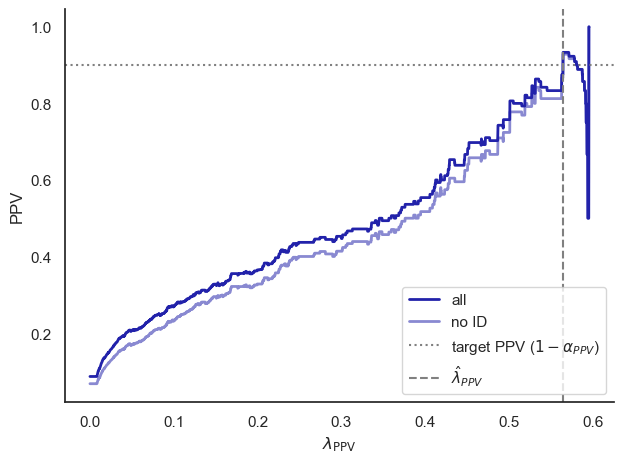

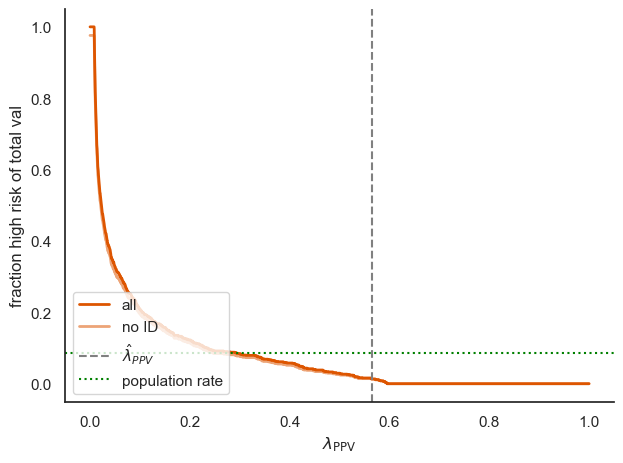

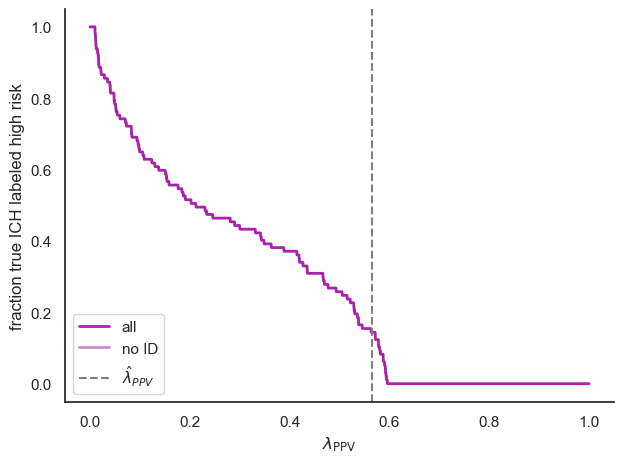

In [9]:
# Plot numerics
sns.set(style='white')
highrisk_correct = [((val_phats_hi > lam) & val_labels).sum()/(val_phats_hi > lam).sum() for lam in lambdas]
highrisk_correct_no_id = [((val_phats_hi > lam) & no_id & val_labels).sum()/((val_phats_hi > lam) & no_id).sum() for lam in lambdas]
highrisk_correct_no_pid = [((val_phats_hi > lam) & no_pid & val_labels).sum()/((val_phats_hi > lam) & no_pid).sum() for lam in lambdas]
highrisk_correct_no_did = [((val_phats_hi > lam) & no_did & val_labels).sum()/((val_phats_hi > lam) & no_did).sum() for lam in lambdas]
fraction_highrisk_curve = [(val_phats_hi > lam).mean() for lam in lambdas]
fraction_highrisk_curve_no_id = [((val_phats_hi > lam) & no_id).mean() for lam in lambdas]
fraction_highrisk_curve_no_pid = [((val_phats_hi > lam) & no_pid).mean() for lam in lambdas]
fraction_highrisk_curve_no_did = [((val_phats_hi > lam) & no_did).mean() for lam in lambdas]
fraction_ich_correct_curve = [((val_phats_hi > lam) & val_labels).sum()/val_labels.sum() for lam in lambdas]
fraction_ich_correct_curve_no_id = [((val_phats_hi > lam) & val_labels & no_id).sum()/val_labels[no_id].sum() for lam in lambdas]
fraction_ich_correct_curve_no_pid = [((val_phats_hi > lam) & val_labels & no_pid).sum()/val_labels[no_pid].sum() for lam in lambdas]
fraction_ich_correct_curve_no_did = [((val_phats_hi > lam) & val_labels & no_did).sum()/val_labels[no_did].sum() for lam in lambdas]

# Make plots non-overlapping
plt.figure()
plt.plot(lambdas,highrisk_correct,label='all',color='#2222AA',linewidth=2)
plt.plot(lambdas,highrisk_correct_no_id,label='no ID',color='#2222AA88',linewidth=2)
plt.gca().axhline(y=1-alpha_hi,linewidth=1.5,linestyle='dotted',label=r'target PPV ($1-\alpha_{PPV}$)',color='gray')
plt.gca().axvline(x=lhat_highrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{PPV}$',color='gray')
sns.despine(top=True,right=True)
plt.legend(loc='lower right')
plt.xlabel(r'$\lambda_{\rm PPV}$')
plt.ylabel('PPV')
plt.tight_layout()
plt.savefig('./plots/ppv_vs_lambda_big.pdf')
plt.show()

plt.figure()
plt.plot(lambdas,fraction_highrisk_curve,color='#DD5500', label='all', linewidth=2)
plt.plot(lambdas,fraction_highrisk_curve_no_id,color='#DD550088', label='no ID', linewidth=2)
plt.gca().axvline(x=lhat_highrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{PPV}$',color='gray')
plt.gca().axhline(y=val_frac_positive,linewidth=1.5,linestyle='dotted',label=r'population rate',color='green')
sns.despine(top=True,right=True)
plt.legend(loc='lower left')
plt.xlabel(r'$\lambda_{\rm PPV}$')
plt.ylabel('fraction high risk of total val')
plt.tight_layout()
plt.savefig('./plots/marginal_fraction_highrisk_big.pdf')
plt.show()

plt.figure()
plt.plot(lambdas,fraction_ich_correct_curve,color='#AA22AA',label='all', linewidth=2)
plt.plot(lambdas,fraction_ich_correct_curve_no_id,color='#AA22AA88', label='no ID', linewidth=2)
plt.gca().axvline(x=lhat_highrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{PPV}$',color='gray')
sns.despine(top=True,right=True)
plt.legend(loc='lower left')
plt.xlabel(r'$\lambda_{\rm PPV}$')
plt.ylabel('fraction true ICH labeled high risk')
plt.tight_layout()
plt.savefig('./plots/true_positive_rate_big.pdf')
plt.show()

In [10]:
# Define selective risk
def selective_frac_ich(lam): return cal_labels[cal_phats_lo >= lam].sum()/(cal_phats_lo >= lam).sum()
def nlambda(lam): return (cal_phats_lo >= lam).sum()
lambdas_lowrisk = np.array([lam for lam in lambdas if nlambda(lam) >= 500]) # Make sure there's some data in the top bin.
def invert_for_ub(r,lam): return binom.cdf(selective_frac_ich(lam)*nlambda(lam),nlambda(lam),r)-delta
# Construct upper bound
def selective_risk_ub(lam): return brentq(invert_for_ub,0,0.999,args=(lam,))
# Scan to choose lamabda hat
for lhat_lowrisk in reversed(lambdas_lowrisk):
    if selective_risk_ub(lhat_lowrisk-1/lambdas_lowrisk.shape[0]) > alpha_lo: break
# Deploy procedure on test data
predictions_lowrisk = val_phats_lo >= lhat_lowrisk

In [11]:
print(lhat_lowrisk, lambdas_lowrisk.max())
print(selective_risk_ub(lhat_lowrisk), alpha_lo)
print(val_labels[val_phats_lo >= lhat_lowrisk].sum()/(val_phats_lo >= lhat_lowrisk).sum())

0.9041808361672334 0.9905981196239247
0.0397975224850445 0.04
0.03534777651083238


In [12]:
# Calculate fraction of low risk with no ICH
empirical_lowrisk_noich = 1-val_labels[predictions_lowrisk].mean()
empirical_lowrisk_noich_no_id = 1-val_labels[predictions_lowrisk & no_id].mean()
print(f"The fraction of low risk people with no ICH is: {empirical_lowrisk_noich}")
missed_low = (~val_labels[~predictions_lowrisk]).mean()
print(f"The fraction of non-ICH in the non-low-risk group is: {missed_low}")
fraction_lowrisk = predictions_lowrisk.mean()
print(f"The fraction of low-risk data points is: {fraction_lowrisk} (n={predictions_lowrisk.sum()})")

The fraction of low risk people with no ICH is: 0.9646522234891676
The fraction of non-ICH in the non-low-risk group is: 0.7306122448979592
The fraction of low-risk data points is: 0.7816399286987522 (n=877)


/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/1334394238.py:6: RuntimeWarning: invalid value encountered in scalar divide
  lowrisk_correct = [((val_phats_lo >= lam) & ~val_labels).sum()/(val_phats_lo >= lam).sum() for lam in lambdas]
/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/1334394238.py:7: RuntimeWarning: invalid value encountered in scalar divide
  lowrisk_correct_no_id = [((val_phats_lo >= lam) & no_id & ~val_labels).sum()/((val_phats_lo >= lam) & no_id).sum() for lam in lambdas]
/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/1334394238.py:8: RuntimeWarning: invalid value encountered in scalar divide
  lowrisk_correct_no_pid = [((val_phats_lo >= lam) & no_pid & ~val_labels).sum()/((val_phats_lo >= lam) & no_pid).sum() for lam in lambdas]
/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/1334394238.py:9: RuntimeWarning: invalid value encountered in scalar divide
  lowrisk_correct_no_did = [((val_phats_lo >= 

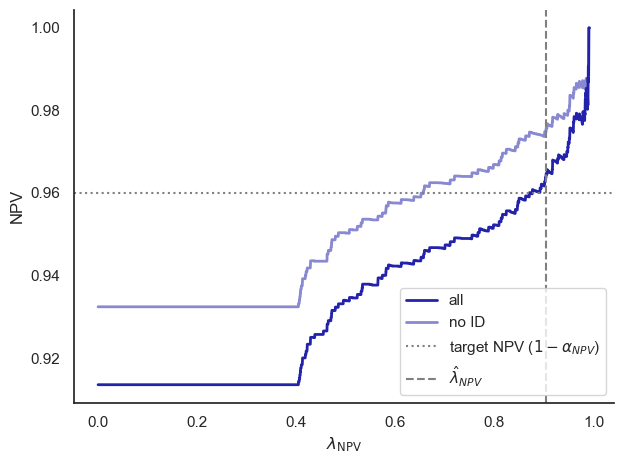

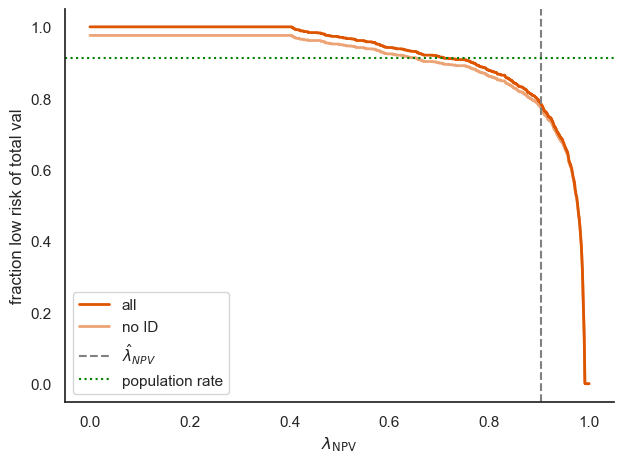

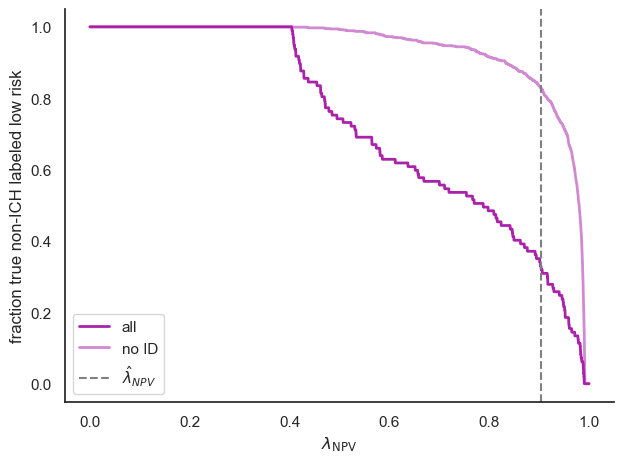

In [13]:
# Plot numerics
sns.set(style='white')
no_pid = np.invert(val_parsing_id)
no_did = np.invert(val_diagnostic_id)
no_id = no_pid & no_did
lowrisk_correct = [((val_phats_lo >= lam) & ~val_labels).sum()/(val_phats_lo >= lam).sum() for lam in lambdas]
lowrisk_correct_no_id = [((val_phats_lo >= lam) & no_id & ~val_labels).sum()/((val_phats_lo >= lam) & no_id).sum() for lam in lambdas]
lowrisk_correct_no_pid = [((val_phats_lo >= lam) & no_pid & ~val_labels).sum()/((val_phats_lo >= lam) & no_pid).sum() for lam in lambdas]
lowrisk_correct_no_did = [((val_phats_lo >= lam) & no_did & ~val_labels).sum()/((val_phats_lo >= lam) & no_did).sum() for lam in lambdas]
fraction_lowrisk_curve = [(val_phats_lo >= lam).mean() for lam in lambdas]
fraction_lowrisk_curve_no_id = [((val_phats_lo >= lam) & no_id).mean() for lam in lambdas]
fraction_lowrisk_curve_no_pid = [((val_phats_lo >= lam) & no_pid).mean() for lam in lambdas]
fraction_lowrisk_curve_no_did = [((val_phats_lo >= lam) & no_did).mean() for lam in lambdas]
fraction_noich_correct_curve = [((val_phats_lo >= lam) & val_labels).sum()/val_labels.sum() for lam in lambdas]
fraction_noich_correct_curve_no_id = [((val_phats_lo >= lam) & ~val_labels & no_id).sum()/(~val_labels & no_id).sum() for lam in lambdas]
fraction_noich_correct_curve_no_pid = [((val_phats_lo >= lam) & ~val_labels & no_pid).sum()/(~val_labels & no_pid).sum() for lam in lambdas]
fraction_noich_correct_curve_no_did = [((val_phats_lo >= lam) & ~val_labels & no_did).sum()/(~val_labels & no_did).sum() for lam in lambdas]

# Make plots non-overlapping
plt.figure()
plt.plot(lambdas,lowrisk_correct,label='all',color='#2222AA',linewidth=2)
plt.plot(lambdas,lowrisk_correct_no_id,label='no ID',color='#2222AA88',linewidth=2)
plt.gca().axhline(y=1-alpha_lo,linewidth=1.5,linestyle='dotted',label=r'target NPV ($1-\alpha_{NPV}$)',color='gray')
plt.gca().axvline(x=lhat_lowrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{NPV}$',color='gray')
sns.despine(top=True,right=True)
plt.legend(loc='lower right')
plt.xlabel(r'$\lambda_{\rm NPV}$')
plt.ylabel('NPV')
plt.tight_layout()
plt.savefig('./plots/npv_vs_lambda_big.pdf')
plt.show()

plt.figure()
plt.plot(lambdas,fraction_lowrisk_curve,color='#DD5500', label='all', linewidth=2)
plt.plot(lambdas,fraction_lowrisk_curve_no_id,color='#DD550088', label='no ID', linewidth=2)
plt.gca().axvline(x=lhat_lowrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{NPV}$',color='gray')
plt.gca().axhline(y=1-val_frac_positive,linewidth=1.5,linestyle='dotted',label=r'population rate',color='green')
sns.despine(top=True,right=True)
plt.legend(loc='lower left')
plt.xlabel(r'$\lambda_{\rm NPV}$')
plt.ylabel('fraction low risk of total val')
plt.tight_layout()
plt.savefig('./plots/marginal_fraction_lowrisk_big.pdf')
plt.show()

plt.figure()
plt.plot(lambdas,fraction_noich_correct_curve,color='#AA22AA',label='all', linewidth=2)
plt.plot(lambdas,fraction_noich_correct_curve_no_id,color='#AA22AA88', label='no ID', linewidth=2)
plt.gca().axvline(x=lhat_lowrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{NPV}$',color='gray')
sns.despine(top=True,right=True)
plt.legend(loc='lower left')
plt.xlabel(r'$\lambda_{\rm NPV}$')
plt.ylabel('fraction true non-ICH labeled low risk')
plt.tight_layout()
plt.savefig('./plots/true_negative_rate_big.pdf')
plt.show()

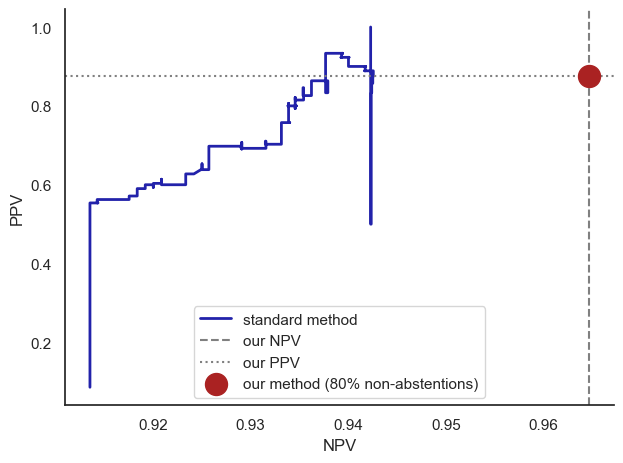

In [14]:
ppv = empirical_highrisk_ich
ppv_no_id = empirical_highrisk_ich_no_id
npv = empirical_lowrisk_noich
npv_no_id = empirical_lowrisk_noich_no_id
fraction_kept_pct = f"{int(np.round((fraction_lowrisk+fraction_highrisk)*100)):d}%"

plt.figure()
plt.plot(lowrisk_correct,highrisk_correct, color='#2222AA', label='standard method', linewidth=2)
#plt.plot(lowrisk_correct_no_id,highrisk_correct_no_id,color='#2222AA88',label='standard method (no ID)', linewidth=2)
plt.gca().axvline(x=npv,linewidth=1.5,linestyle='--',label=f'our NPV',color='gray')
plt.gca().axhline(y=ppv,linewidth=1.5,linestyle='dotted',label=f'our PPV',color='gray')
plt.scatter([npv], [ppv], color='#AA2222', s=250, label=f'our method ({fraction_kept_pct} non-abstentions)',zorder=2)
sns.despine(top=True,right=True)
plt.legend(loc='best')
plt.xlabel('NPV')
plt.ylabel('PPV')
#plt.xlim(0.9,1)
#plt.ylim(0,1)
plt.tight_layout()
plt.savefig('./plots/PPV_NPV_tradeoff_big.pdf')
plt.show()

In [15]:
print(f"PPV: {ppv}, NPV: {npv}, Abstentions: {1-(fraction_lowrisk+fraction_highrisk)}")

PPV: 0.875, NPV: 0.9646522234891676, Abstentions: 0.20409982174688057


In [16]:
# Now save a csv with two columns: case no and class@(1-alpha_hi, 1-alpha_lo)
classification = []
for i in range(predictions_highrisk.shape[0]):
    if predictions_highrisk[i]:
        classification += "P"
    elif predictions_lowrisk[i]:
        classification += "N"
    else:
        classification += "U"
classification = np.array(classification)
df = pd.DataFrame(np.vstack([classification]).T, columns=[f"class@ppv{1-alpha_hi}xnpv{1-alpha_lo}"])
os.makedirs('../results/csv-results/', exist_ok=True)
df.to_csv(f"../results/csv-results/class@ppv{1-alpha_hi}xnpv{1-alpha_lo}.csv")

In [17]:
data = np.load('../data/proc-small-clean.npz')
small_probs = data['slice_probs']
small_labels = data['labels']

small_phats_hi = cls.predict_proba(small_probs)[:,1]
small_phats_lo = cls.predict_proba(small_probs)[:,0]
small_predictions_lowrisk = small_phats_lo >= lhat_lowrisk
small_predictions_highrisk = small_phats_hi >= lhat_highrisk

small_frac_positive = small_labels.mean()
small_fraction_lowrisk = small_predictions_lowrisk.mean()
small_fraction_highrisk = small_predictions_highrisk.mean()

In [18]:
print(f"lhat_lowrisk: {lhat_lowrisk}, lhat_highrisk: {lhat_highrisk}")

lhat_lowrisk: 0.9041808361672334, lhat_highrisk: 0.5643128625725145


In [19]:
small_ppv = (small_predictions_highrisk & small_labels).sum()/small_predictions_highrisk.sum()
small_npv = (small_predictions_lowrisk & ~small_labels).sum()/small_predictions_lowrisk.sum()
small_frac_abstained = 1-(small_predictions_highrisk.sum() + small_predictions_lowrisk.sum())/small_predictions_lowrisk.shape[0]
print(f"PPV: {small_ppv}, NPV: {small_npv}, Abstentions: {small_frac_abstained}")

PPV: 0.9787234042553191, NPV: 0.9472759226713533, Abstentions: 0.2551390568319226


In [20]:
# Now save a csv with two columns: case no and class@(1-alpha_hi, 1-alpha_lo)
small_classification = []
for i in range(small_predictions_highrisk.shape[0]):
    if small_predictions_highrisk[i]:
        small_classification += "P"
    elif small_predictions_lowrisk[i]:
        small_classification += "N"
    else:
        small_classification += "U"
small_classification = np.array(small_classification)
small_df = pd.DataFrame(np.vstack([small_classification]).T, columns=[f"class@ppv{1-alpha_hi}xnpv{1-alpha_lo}"])
os.makedirs('../results/small-csv-results/', exist_ok=True)
small_df.to_csv(f"../results/small-csv-results/class@ppv{1-alpha_hi}xnpv{1-alpha_lo}.csv")

/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/398284267.py:3: RuntimeWarning: invalid value encountered in scalar divide
  small_highrisk_correct = [((small_phats_hi >= lam) & small_labels).sum()/(small_phats_hi >= lam).sum() for lam in lambdas]


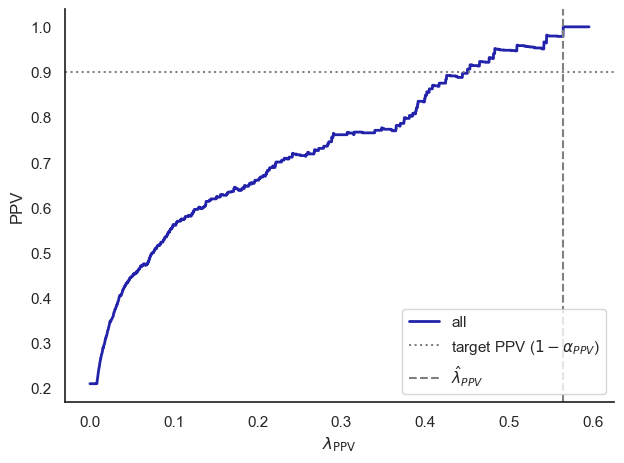

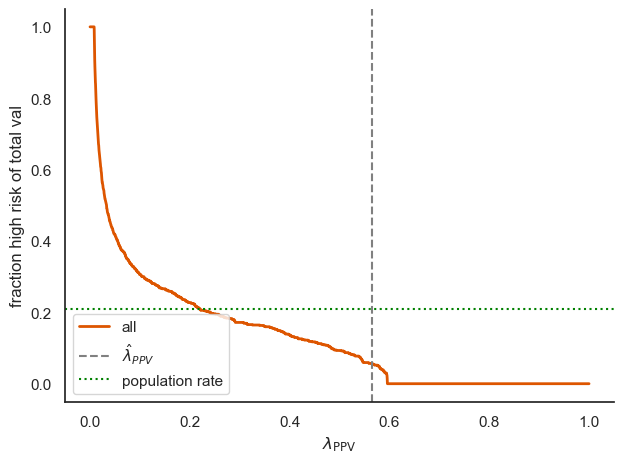

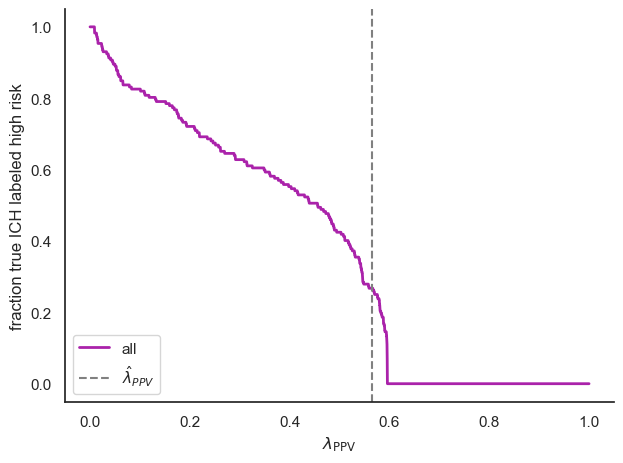

/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/398284267.py:43: RuntimeWarning: invalid value encountered in scalar divide
  small_lowrisk_correct = [((small_phats_lo >= lam) & ~small_labels).sum()/(small_phats_lo >= lam).sum() for lam in lambdas]


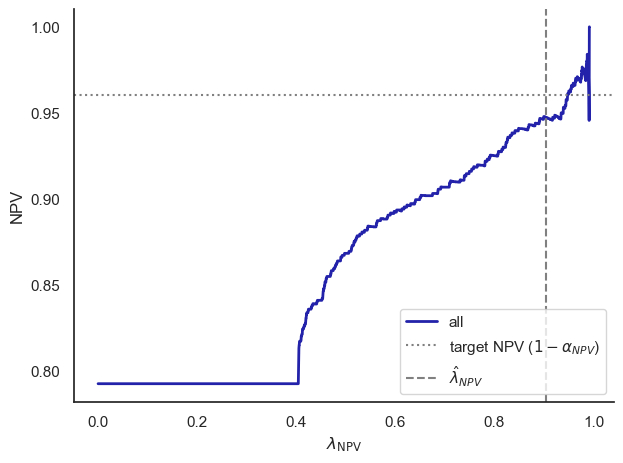

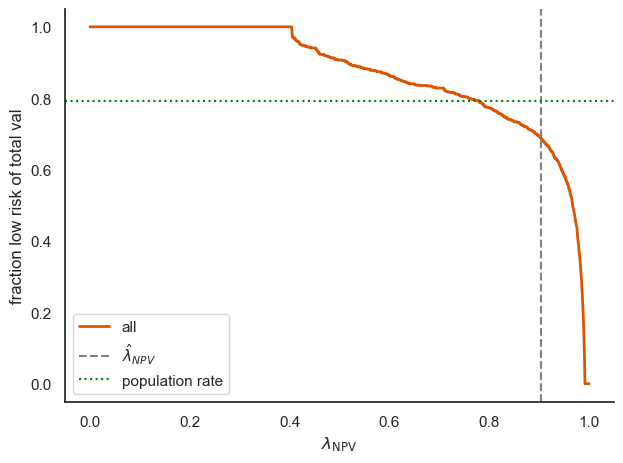

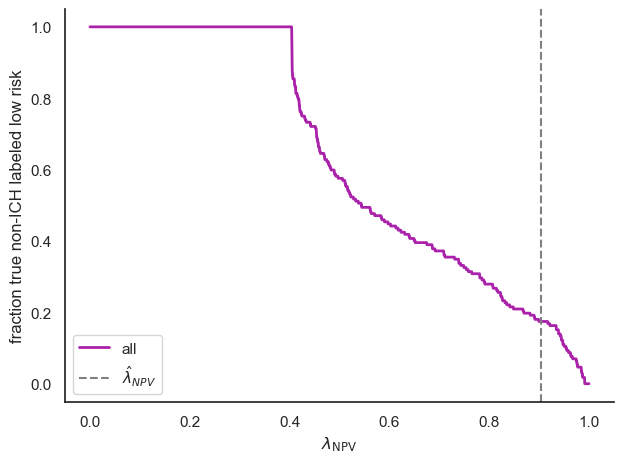

In [21]:
# Plot numerics
sns.set(style='white')
small_highrisk_correct = [((small_phats_hi >= lam) & small_labels).sum()/(small_phats_hi >= lam).sum() for lam in lambdas]
small_fraction_highrisk_curve = [(small_phats_hi >= lam).mean() for lam in lambdas]
small_fraction_ich_correct_curve = [((small_phats_hi >= lam) & small_labels).sum()/small_labels.sum() for lam in lambdas]

# Make plots non-overlapping
plt.figure()
plt.plot(lambdas,small_highrisk_correct,label='all',color='#2222AA',linewidth=2)
plt.gca().axhline(y=1-alpha_hi,linewidth=1.5,linestyle='dotted',label=r'target PPV ($1-\alpha_{PPV}$)',color='gray')
plt.gca().axvline(x=lhat_highrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{PPV}$',color='gray')
sns.despine(top=True,right=True)
plt.legend(loc='lower right')
plt.xlabel(r'$\lambda_{\rm PPV}$')
plt.ylabel('PPV')
plt.tight_layout()
plt.savefig('./plots/ppv_vs_lambda_small.pdf')
plt.show()

plt.figure()
plt.plot(lambdas,small_fraction_highrisk_curve,color='#DD5500', label='all', linewidth=2)
plt.gca().axvline(x=lhat_highrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{PPV}$',color='gray')
plt.gca().axhline(y=small_frac_positive,linewidth=1.5,linestyle='dotted',label=r'population rate',color='green')
sns.despine(top=True,right=True)
plt.legend(loc='lower left')
plt.xlabel(r'$\lambda_{\rm PPV}$')
plt.ylabel('fraction high risk of total val')
plt.tight_layout()
plt.savefig('./plots/marginal_fraction_highrisk_small.pdf')
plt.show()

plt.figure()
plt.plot(lambdas,small_fraction_ich_correct_curve,color='#AA22AA',label='all', linewidth=2)
plt.gca().axvline(x=lhat_highrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{PPV}$',color='gray')
sns.despine(top=True,right=True)
plt.legend(loc='lower left')
plt.xlabel(r'$\lambda_{\rm PPV}$')
plt.ylabel('fraction true ICH labeled high risk')
plt.tight_layout()
plt.savefig('./plots/true_positive_rate_small.pdf')
plt.show()

small_lowrisk_correct = [((small_phats_lo >= lam) & ~small_labels).sum()/(small_phats_lo >= lam).sum() for lam in lambdas]
small_fraction_lowrisk_curve = [(small_phats_lo >= lam).mean() for lam in lambdas]
small_fraction_noich_correct_curve = [((small_phats_lo >= lam) & small_labels).sum()/small_labels.sum() for lam in lambdas]

# Make plots non-overlapping
plt.figure()
plt.plot(lambdas,small_lowrisk_correct,label='all',color='#2222AA',linewidth=2)
plt.gca().axhline(y=1-alpha_lo,linewidth=1.5,linestyle='dotted',label=r'target NPV ($1-\alpha_{NPV}$)',color='gray')
plt.gca().axvline(x=lhat_lowrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{NPV}$',color='gray')
sns.despine(top=True,right=True)
plt.legend(loc='lower right')
plt.xlabel(r'$\lambda_{\rm NPV}$')
plt.ylabel('NPV')
plt.tight_layout()
plt.savefig('./plots/npv_vs_lambda_small.pdf')
plt.show()

plt.figure()
plt.plot(lambdas,small_fraction_lowrisk_curve,color='#DD5500', label='all', linewidth=2)
plt.gca().axvline(x=lhat_lowrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{NPV}$',color='gray')
plt.gca().axhline(y=1-small_frac_positive,linewidth=1.5,linestyle='dotted',label=r'population rate',color='green')
sns.despine(top=True,right=True)
plt.legend(loc='lower left')
plt.xlabel(r'$\lambda_{\rm NPV}$')
plt.ylabel('fraction low risk of total val')
plt.tight_layout()
plt.savefig('./plots/marginal_fraction_lowrisk_small.pdf')
plt.show()

plt.figure()
plt.plot(lambdas,small_fraction_noich_correct_curve,color='#AA22AA',label='all', linewidth=2)
plt.gca().axvline(x=lhat_lowrisk,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}_{NPV}$',color='gray')
sns.despine(top=True,right=True)
plt.legend(loc='lower left')
plt.xlabel(r'$\lambda_{\rm NPV}$')
plt.ylabel('fraction true non-ICH labeled low risk')
plt.tight_layout()
plt.savefig('./plots/true_negative_rate_small.pdf')
plt.show()

In [22]:
# Evaluate hand-designed rule
print(evaluate(sgmds, labels)) # Hand-designed rule
print(evaluate(sgmds, labels, cls=cls)) # Logistic regression

{'ppv': 0.7482758620689656, 'npv': 0.9627403846153846, 'coverage': 0.8627899379287814, 'fn': 186, 'fp': 73, 'tp': 217, 'tn': 4806}
{'ppv': 0.9463087248322147, 'npv': 0.9598283931357254, 'coverage': 0.8619732113688336, 'fn': 206, 'fp': 8, 'tp': 141, 'tn': 4922}


In [23]:
# Evaluate one point on the ROC curve with 95% NPV
lambdas_roc = np.linspace(0,1,5000)
npv_roc = np.nan_to_num(np.array([ (1-labels)[phats_lo >= lam].sum()/(phats_lo >= lam).sum() for lam in lambdas_roc ]), 1)
lhat_roc = lambdas_roc[np.argmin(np.abs(npv_roc - 0.95))]
fn_roc = labels[phats_lo >= lhat_roc].sum()
fp_roc = (1-labels)[phats_lo < lhat_roc].sum()
tp_roc = labels[phats_lo < lhat_roc].sum()
tn_roc = (1-labels)[phats_lo >= lhat_roc].sum()
print('ppv:', tp_roc/(tp_roc+fp_roc), 'npv:', tn_roc/(tn_roc+fn_roc), 'fn:', fn_roc, 'fp:', fp_roc, 'tp:', tp_roc, 'tn:', tn_roc)

ppv: 0.5501930501930502 npv: 0.9500356887937188 fn: 280 fp: 233 tp: 285 tn: 5324


/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_35376/1681597686.py:3: RuntimeWarning: invalid value encountered in scalar divide
  npv_roc = np.nan_to_num(np.array([ (1-labels)[phats_lo >= lam].sum()/(phats_lo >= lam).sum() for lam in lambdas_roc ]), 1)


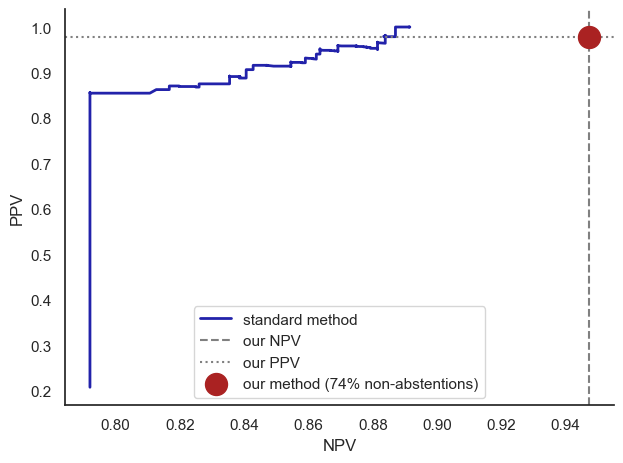

In [24]:
small_fraction_kept_pct = f"{int(np.round((small_fraction_lowrisk+small_fraction_highrisk)*100)):d}%"

plt.figure()
plt.plot(small_lowrisk_correct,small_highrisk_correct, color='#2222AA', label='standard method', linewidth=2)
#plt.plot(lowrisk_correct_no_id,highrisk_correct_no_id,color='#2222AA88',label='standard method (no ID)', linewidth=2)
plt.gca().axvline(x=small_npv,linewidth=1.5,linestyle='--',label=f'our NPV',color='gray')
plt.gca().axhline(y=small_ppv,linewidth=1.5,linestyle='dotted',label=f'our PPV',color='gray')
plt.scatter([small_npv], [small_ppv], color='#AA2222', s=250, label=f'our method ({small_fraction_kept_pct} non-abstentions)',zorder=2)
sns.despine(top=True,right=True)
plt.legend(loc='best')
plt.xlabel('NPV')
plt.ylabel('PPV')
#plt.xlim(0.9,1)
#plt.ylim(0,1)
plt.tight_layout()
plt.savefig('./plots/PPV_NPV_tradeoff_small.pdf')
plt.show()